# Preprocessing & analysis of Kanye West's lyrics

In [3]:
import json
import nltk
import re
import contractions
from collections import Counter
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore
import pyLDAvis.gensim
from sentence_transformers import SentenceTransformer, util
from IPython.display import display
import statistics

import numpy as np

In [4]:
album_list = ["The College Dropout", "Late Registration", "Graduation", "808s & Heartbreak", "My Beautiful Dark Twisted Fantasy", "Yeezus",
              "The Life of Pablo", "Ye", "Jesus Is King", "Donda", "Kids See Ghosts", "Watch The Throne"] # list of all Kanye's studio albums
albums = {"The College Dropout":"", "Late Registration":"", "Graduation":"", "808s & Heartbreak":"", "My Beautiful Dark Twisted Fantasy":"", "Yeezus":"",
          "The Life of Pablo":"", "Ye":"", "Jesus Is King":"", "Donda":"", "Kids See Ghosts":"", "Watch The Throne":""} # dictionary, key is studio album, value will be lyrics of all songs combined into one document

adlibs = ["get", "oh", "uh", "huh", "heh", "yeah", "yah", "uhuh",
          "ayy", "ooh", "woah", "hmm", "hm", 'mm', 'mmm', "bam", "duh", "mmh", "nah", "mhm"] #adlibs, to be added to stopword list

with open("data/songs.json", "r", encoding="utf-8") as file:
    lyrics = json.load(file)
full_lyrics = lyrics


In [5]:
def preprocess():
    """Preprocess the lyrics dictionary. """
    for song in lyrics: # iterate through all songs
        expanded_words = []
        text = lyrics[song]["lyrics"].lower() # put everything into lowercase
        text = re.sub("\n", " ", text) # remove newlines
        text = re.sub('[*,\.!?]', '', text) # remove punctuation and other chars

        for word in text.split():
                expanded_words.append(contractions.fix(word)) # remove contractions i.e. we'll -> we will
        text = expanded_words
        text = ' '.join(text) # join back to string
        text = nltk.WordPunctTokenizer().tokenize(text) # tokenize
        text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1] # lemmatize verbs
        text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='n') for token in text if len(token)>1] # lemmatize nouns
        text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='a') for token in text if len(token)>1] # lemmatize adjectives
        stopword_list = nltk.corpus.stopwords.words("english") # initialize stopword list
        stopword_list.extend(adlibs) # add adlibs into the stopword list
        removed_stopwords = []
        for word in text: # iterate through words, if the word is not in stopwords, keep it. Remov otherwise
            if word not in stopword_list:
                removed_stopwords.append(word)
        text = removed_stopwords
        lyrics[song]["lyrics"] = text # replace original text with preprocessed text

<>:7: DeprecationWarning: invalid escape sequence \.
<>:7: DeprecationWarning: invalid escape sequence \.
C:\Users\vojta\AppData\Local\Temp\ipykernel_14104\2399634017.py:7: DeprecationWarning: invalid escape sequence \.
  text = re.sub('[*,\.!?]', '', text) # remove punctuation and other chars


In [6]:
def generate_wordcloud(album):
    """Method to generate wordclouds with 200 most used words on each album.
    Not really useful for any of the task, just thought it might be interesting """
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          min_font_size = 10,
                          collocations=False,
                          random_state=1).generate(albums[album],)
    plt.figure(1, figsize = (10, 10), facecolor = None)
    plt.axis("off")
    plt.imshow(wordcloud)
    plt.savefig(f'{album}.png') # save as png

In [7]:
def get_individual_albums(texts):
    """Method to gather lyrics from all songs of each album and connect them into one large document"""
    for album in album_list:
        for song in lyrics:
            if texts[song]["album"] == album:
              albums[album] = albums[album] + ' '.join(texts[song]["lyrics"])

In [8]:
preprocess()
get_individual_albums(lyrics)

In [9]:
# for album in albums: # iterate through album list and generate wordclouds
#     generate_wordcloud(album)

### TF- IDF Vectorization
TF-IDF vectorization lets us use the dataset for clustering

In [10]:
for song in lyrics: # join lyrics into a string instead of a list for each song
    lyrics[song]["lyrics"] = " ".join(lyrics[song]["lyrics"])
df_lyrics = pd.DataFrame.from_dict(lyrics, orient="index") # create a dataframe from dict

In [11]:
df_lyrics.head()

,album,lyrics
Intro,The College Dropout,kanye talk minute faculty member wonderin coul...
We Don’t Care,The College Dropout,perfect song kid sing people drug dealin stack...
Graduation Day,The College Dropout,fuck kanye tell shit kid give muthafuckin grad...
All Falls Down,The College Dropout,fall real one baby tellin fall chi town stand ...
I’ll Fly Away,The College Dropout,one glad morning life fly away land joy shall ...


In [12]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95) # used metaparameters as advised on stackoverflow
X = vectorizer.fit_transform(df_lyrics['lyrics'])

### Clustering
Aim is to create clusters of songs that use similar words. This uses the bag of words approach and doesn't really mean that the songs are thematically similar, although it could.

In [13]:
kmeans = KMeans(n_clusters=5, random_state=420) # decided to go with 5 clusters, was not able to perform k-elbow test to determine the best. Random state for replicability
kmeans.fit(X) # fit data into our kmeans model

C:\Users\vojta\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=420)

In [14]:
df_lyrics['cluster'] = kmeans.labels_

In [15]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(kmeans.labels_).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
df_lyrics['x0'] = x0
df_lyrics['x1'] = x1

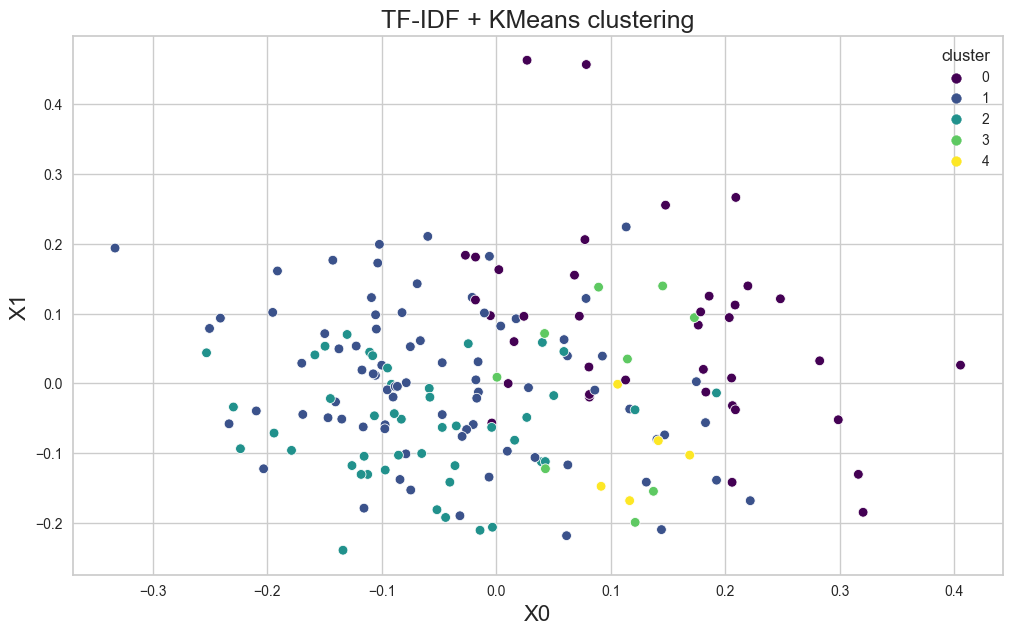

In [16]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_lyrics, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

### From the top 10 terms in each cluster from the tf-idf matrix we can assume what the songs in each cluster are about
Cluster 0: spiritual songs with various mentions of the holy trinity and Kanye's mother Donda
Cluster 1: songs that often mention love and feelings
Cluster 2: songs about women, lots of profanities and other stereotypical rapper lyrics
Cluster 3: songs with mentions of god, devil, possibly discussing Kanye's relationship with god
Cluster 4: songs with expressions of various feelings, possibly personal struggle

In [17]:
get_top_keywords(20)


Cluster 0
hallelujah,need,light,like,donda,pray,new,want,see,thank,every,let,keep,life,know,go,make,god,jesus,lord

Cluster 1
shit,think,never,man,would,back,could,take,make,want,tell,let,nigga,cannot,girl,see,say,know,go,like

Cluster 2
would,fuckin,one,say,go,right,bad,make,want,black,gon,love,need,hand,bitch,like,know,shit,fuck,nigga

Cluster 3
thing,breathe,finish,nothing,alive,baby,turn,devil,go,lord,gon,love,lie,sun,na,know,alright,god,okay,wave

Cluster 4
roll,fade,na,yes,many,never,feel,could,heaven,take,inside,scar,soon,leave,know,deep,far,amaze,moon,lift


In [18]:
df_lyrics["cluster"].value_counts() # show number of songs assigned to each cluster

1    79
2    45
0    38
3     9
4     5
Name: cluster, dtype: int64

In [19]:
df_lyrics[df_lyrics["cluster"] == 0]

,album,lyrics,cluster,x0,x1
I’ll Fly Away,The College Dropout,one glad morning life fly away land joy shall ...,0,0.316389,-0.130246
Jesus Walks,The College Dropout,war war terrorism racism war jesus walk god sh...,0,-0.018033,0.180826
Good Night,Graduation,sure anymore ymore knock door door face know j...,0,0.081474,-0.019684
Welcome To Heartbreak,808s & Heartbreak,friend show picture kid could show picture cri...,0,0.010480,-0.000254
Love Lockdown,808s & Heartbreak,love way want run love vibe wrong haunt way ho...,0,0.081505,-0.015880
Dark Fantasy,My Beautiful Dark Twisted Fantasy,might think peep scene real one far mean water...,0,-0.003756,-0.056788
Ultralight Beam,The Life of Pablo,yes god want devil house god yes lord want lor...,0,0.147962,0.255163
Low Lights,The Life of Pablo,want give testimony life good know tell love m...,0,0.181009,0.020052
Violent Crimes,Ye,fallin dreamin talkin sleep know want cry nigh...,0,0.081045,0.023395
Every Hour,Jesus Is King,sing every hour every hour til power every min...,0,0.298862,-0.052148


In [20]:
df_lyrics[df_lyrics["cluster"] == 1]

,album,lyrics,cluster,x0,x1
Intro,The College Dropout,kanye talk minute faculty member wonderin coul...,1,0.144398,-0.209403
Spaceship,The College Dropout,work grave shift make shit wish could buy spac...,1,-0.108924,0.122814
Never Let Me Down,The College Dropout,baby hahahaha turn motherfuckin music come tru...,1,-0.101983,0.199080
Workout Plan,The College Dropout,wassup girl hey girl hey know finally shit tog...,1,-0.031648,-0.189564
The New Workout Plan,The College Dropout,pop kanye west right summer workout tape lady ...,1,-0.137342,0.049406
...,...,...,...,...,...
Niggas in Paris,Watch The Throne,go skate one song one song ball hard motherfuc...,1,-0.203123,-0.122324
Otis,Watch The Throne,make easy easy bear regret girl forget love ha...,1,-0.074966,0.052535
Murder to Excellence,Watch The Throne,bloody murder murder murder bloody murder murd...,1,0.003981,0.082077
Made in America,Watch The Throne,bring darkness sweet king martin sweet queen c...,1,0.092798,0.039061


In [21]:
df_lyrics[df_lyrics["cluster"] == 2]

,album,lyrics,cluster,x0,x1
We Don’t Care,The College Dropout,perfect song kid sing people drug dealin stack...,2,-0.130211,0.069991
Graduation Day,The College Dropout,fuck kanye tell shit kid give muthafuckin grad...,2,-0.065039,-0.100422
All Falls Down,The College Dropout,fall real one baby tellin fall chi town stand ...,2,-0.110488,0.044725
Get ’Em High,The College Dropout,tryna catch beat tryna catch beat tryna catch ...,2,-0.253008,0.043728
Two Words,The College Dropout,street playa mail two place end either dead ja...,2,-0.149478,0.053193
Drive Slow,Late Registration,boom boom boom boom drive slow homie drive slo...,2,-0.091467,-0.001264
Back to Basics,Late Registration,let take back basic shit bad converse need new...,2,0.016135,-0.081382
We Can Make It Better,Late Registration,break make good break make good break make goo...,2,-0.107867,0.039607
I Wonder,Graduation,find dream come true wonder know mean mean won...,2,0.050310,-0.017490
Barry Bonds,Graduation,wait people pay paper damn cannot stand want s...,2,-0.051701,-0.180917


In [22]:
df_lyrics[df_lyrics["cluster"] == 3]

,album,lyrics,cluster,x0,x1
See You In My Nightmares,808s & Heartbreak,cold cold cold right put fight quite cut light...,3,0.000718,0.008767
"Father Stretch My Hands, Pt. 1",The Life of Pablo,power power power power power power father you...,3,0.137396,-0.154561
Waves,The Life of Pablo,turn step bitch like turn one bitch like one b...,3,0.121430,-0.199025
Siiiiiiiiilver Surffffeeeeer Intermission,The Life of Pablo,yeezy yeezy good boy max go check appreciate l...,3,0.043037,-0.122218
On God,Jesus Is King,yo pi erre yo pi erre much favor side accept l...,3,0.089471,0.137773
God Breathed,Donda,know god breathe know god breathe know god bre...,3,0.145473,0.139450
24,Donda,dear god make alright make alright dear lord m...,3,0.173148,0.094095
Lord I Need You,Donda,well lord need wrap arm around wrap arm around...,3,0.042310,0.071409
No Church in the Wild,Watch The Throne,human mob mob king king god god non believer b...,3,0.114680,0.034866


In [23]:
df_lyrics[df_lyrics["cluster"] == 4]

,album,lyrics,cluster,x0,x1
Amazing,808s & Heartbreak,amaze reason everybody fire even exhaust barel...,4,0.106111,-0.001270
Fade,The Life of Pablo,love fadin love fadin love fadin feel fadin on...,4,0.116621,-0.167925
Moon,Donda,want go moon leave soon leave soon could could...,4,0.169077,-0.102748
Fire,Kids See Ghosts,love shit talkin love shit talkin nothing good...,4,0.141658,-0.082095
Lift Off,Watch The Throne,engine run gon take moon take star many people...,4,0.091657,-0.147380


# Topic modelling
The goal of this task is to identify the most popular topics accross all of Kanye's lyrics

In [24]:
lyric_list = [ x["lyrics"].split() for x in lyrics.values()] #
bigram = gensim.models.Phrases(lyric_list)

In [25]:
lyric_dict = corpora.Dictionary(lyric_list) # create a disctionary from all songs' lyrics
texts = lyric_list
texts = [bigram[line] for line in texts]
corpus = [lyric_dict.doc2bow(text) for text in texts] # create corpus

In [26]:
lda_model = LdaMulticore(corpus=corpus, id2word=lyric_dict, num_topics=10, random_state=420) # lda model with selected attributes, num_topics = 10, random_state=420 for replicability

In [27]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, lyric_dict) # only viable to visualize that i found
# if it throws an rror, it needs pandas <2.0.0. due to a bug

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.011917  0.004848       1        1  24.793118
3     -0.023433 -0.017136       2        1  18.756100
7     -0.009402 -0.005434       3        1  14.029251
5     -0.018686  0.016249       4        1  10.335647
1      0.006486  0.014506       5        1   9.592851
6     -0.003144  0.010449       6        1   8.856433
2      0.012638 -0.000073       7        1   4.146023
8      0.006643  0.004252       8        1   4.063450
9      0.008736 -0.030309       9        1   3.260791
4      0.032081  0.002648      10        1   2.166338, topic_info=       Term        Freq       Total Category  logprob  loglift
105    know  677.000000  677.000000  Default  30.0000  30.0000
11     love  237.000000  237.000000  Default  29.0000  29.0000
108    like  632.000000  632.000000  Default  28.0000  28.0000
121   nigga  310.000000  310.000000  Default  27.0000  27.0000
86       go  528.000000  528.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
45   cannot    2.756125  193.067784  Topic10  -5.6865  -0.4171
77     feel    2.676879  213.223394  Topic10  -5.7157  -0.5456
300    need    2.644512  225.048200  Topic10  -5.7279  -0.6117
2     could    2.419080  173.053217  Topic10  -5.8170  -0.4381
219   right    2.408426  234.481208  Topic10  -5.8214  -0.7463

[774 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3625      3  0.181588    300
3625      5  0.544765    300
3625      7  0.181588    300
3626      3  0.423817    500
3626      5  0.423817    500
...     ...       ...    ...
2867      4  0.220377  ymore
2867      5  0.440754  ymore
2785      3  0.245624  zonin
2785      5  0.491249  zonin
4942      4  0.635481  еmpty

[1676 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 8, 6, 2, 7, 3, 9, 10, 5])

### Similarity analysis
Goal is to compare individual songs accross Kanye's discography and find the most similar ones. I will be comparing two albums at a time.
As comparing all songs against each other would be too tedious to run, I decided to compary only a selection of albums.

In [28]:
model = SentenceTransformer('all-mpnet-base-v2') # selected a model that was reported as best performing on sentence-transformer documentation

In [29]:
def remove_adlibs(text):
    """Remove adlibs"""
    removed_adlibs = []
    for word in text.split(" "):
        if word not in adlibs:
            removed_adlibs.append(word)
    return removed_adlibs

In [30]:
def similarity_analysis(album1, album2):
    songs_1 = [re.sub("[\n()]"," ",full_lyrics[x]["lyrics"]) for x in full_lyrics if full_lyrics[x]["album"] == album1] # remove \n and ()
    songs_2 = [re.sub("[\n()]"," ",full_lyrics[x]["lyrics"]) for x in full_lyrics if full_lyrics[x]["album"] == album2] # remove \n and ()
    songs_1 = [remove_adlibs(x) for x in songs_1] # remove adlibs
    songs_2 = [remove_adlibs(x) for x in songs_2] # remove adlibs
    song_names_1 = [x for x in full_lyrics if full_lyrics[x]["album"] == album1] # get song names
    song_names_2 = [x for x in full_lyrics if full_lyrics[x]["album"] == album2] # get song names

    embeddings1 = model.encode(songs_1, convert_to_tensor=True) # create embeddings
    embeddings2 = model.encode(songs_2, convert_to_tensor=True) # create embeddings
    cosine_scores = util.cos_sim(embeddings1, embeddings2) # compute cosine similarity
    most_similar = ("","",0) # create a tuple representing the most similar
    least_similar = ("","",1) # create a tuple representing the least similar
    for i in range(len(songs_1)): # itarate and find the least and most similar songs from the albums
        for j in range(len(songs_2)):
            print("{} \t\t {} \t\t Score: {:.4f}".format(song_names_1[i], song_names_2[j], cosine_scores[i][j]))
            if cosine_scores[i][j] > most_similar[2] and song_names_1[i] != song_names_2[j]: # added a condition of not being the same song in case I want to compare songs within one album
                most_similar = (song_names_1[i], song_names_2[j], cosine_scores[i][j])
            if cosine_scores[i][j] < least_similar[2]:
                least_similar = (song_names_1[i], song_names_2[j], cosine_scores[i][j])
    sns.heatmap(cosine_scores, xticklabels=song_names_2, yticklabels=song_names_1, cmap="viridis")

    print(f"Most similar songs from {album1} and {album2}: {most_similar}")
    print(f"Least similar songs from {album1} and {album2}: {least_similar}")


Dark Fantasy 		 Good Morning 		 Score: 0.1641
Dark Fantasy 		 Champion 		 Score: 0.1270
Dark Fantasy 		 Stronger 		 Score: 0.2059
Dark Fantasy 		 I Wonder 		 Score: 0.2354
Dark Fantasy 		 Good Life 		 Score: 0.1704
Dark Fantasy 		 Can’t Tell Me Nothing 		 Score: 0.1963
Dark Fantasy 		 Barry Bonds 		 Score: 0.1668
Dark Fantasy 		 Drunk and Hot Girls 		 Score: 0.1431
Dark Fantasy 		 Flashing Lights 		 Score: 0.1335
Dark Fantasy 		 Everything I Am 		 Score: 0.1973
Dark Fantasy 		 The Glory 		 Score: 0.1822
Dark Fantasy 		 Homecoming 		 Score: 0.2216
Dark Fantasy 		 Big Brother 		 Score: 0.1652
Dark Fantasy 		 Good Night 		 Score: 0.1642
Dark Fantasy 		 Bittersweet Poetry 		 Score: 0.1385
Gorgeous 		 Good Morning 		 Score: 0.2196
Gorgeous 		 Champion 		 Score: 0.1993
Gorgeous 		 Stronger 		 Score: 0.3807
Gorgeous 		 I Wonder 		 Score: 0.4154
Gorgeous 		 Good Life 		 Score: 0.2245
Gorgeous 		 Can’t Tell Me Nothing 		 Score: 0.2803
Gorgeous 		 Barry Bonds 		 Score: 0.2448
Gorgeous 		 Drunk a

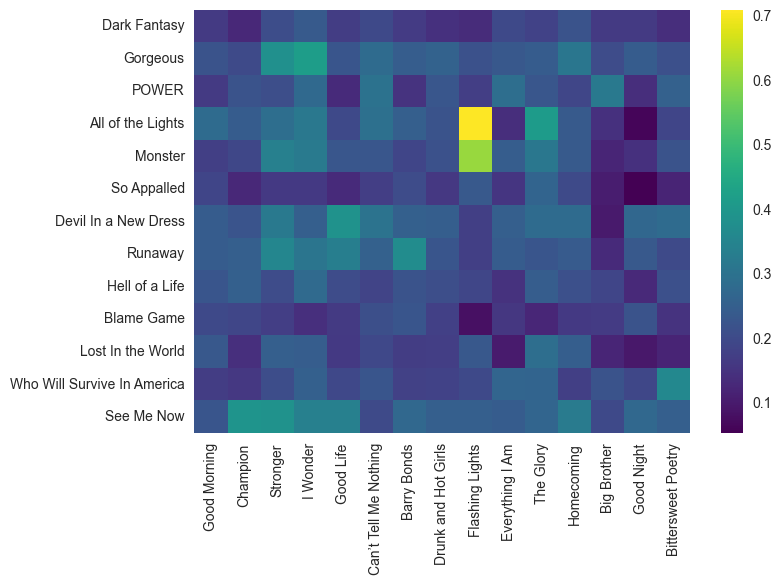

In [31]:
similarity_analysis("My Beautiful Dark Twisted Fantasy", "Graduation")

I Thought About Killing You 		 Feel the Love 		 Score: 0.3552
I Thought About Killing You 		 Fire 		 Score: 0.3662
I Thought About Killing You 		 4th Dimension 		 Score: 0.2160
I Thought About Killing You 		 Freeee (Ghost Town, Pt. 2) 		 Score: 0.3147
I Thought About Killing You 		 Reborn 		 Score: 0.2015
I Thought About Killing You 		 Kids See Ghosts 		 Score: 0.2707
I Thought About Killing You 		 Cudi Montage 		 Score: 0.1323
Yikes 		 Feel the Love 		 Score: 0.2812
Yikes 		 Fire 		 Score: 0.2822
Yikes 		 4th Dimension 		 Score: 0.1383
Yikes 		 Freeee (Ghost Town, Pt. 2) 		 Score: 0.2792
Yikes 		 Reborn 		 Score: 0.0871
Yikes 		 Kids See Ghosts 		 Score: 0.2261
Yikes 		 Cudi Montage 		 Score: 0.1620
All Mine 		 Feel the Love 		 Score: 0.1929
All Mine 		 Fire 		 Score: 0.1422
All Mine 		 4th Dimension 		 Score: 0.2109
All Mine 		 Freeee (Ghost Town, Pt. 2) 		 Score: 0.1346
All Mine 		 Reborn 		 Score: 0.2584
All Mine 		 Kids See Ghosts 		 Score: 0.2047
All Mine 		 Cudi Montage 		 Score

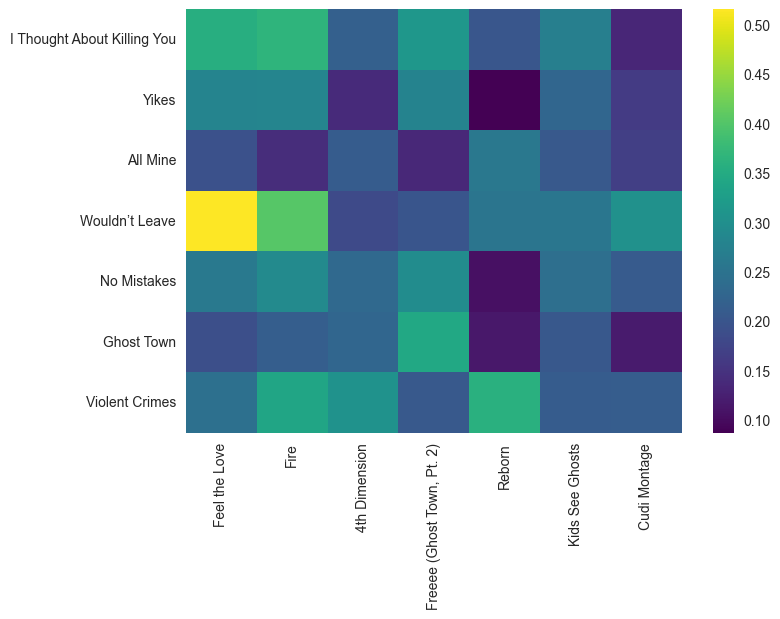

In [32]:
similarity_analysis("Ye", "Kids See Ghosts")

Ultralight Beam 		 Ultralight Beam 		 Score: 1.0000
Ultralight Beam 		 Father Stretch My Hands, Pt. 1 		 Score: 0.2723
Ultralight Beam 		 Pt. 2 		 Score: 0.1338
Ultralight Beam 		 Famous 		 Score: 0.2314
Ultralight Beam 		 Feedback 		 Score: 0.2754
Ultralight Beam 		 Low Lights 		 Score: 0.1774
Ultralight Beam 		 Highlights 		 Score: 0.1661
Ultralight Beam 		 Freestyle 4 		 Score: 0.3847
Ultralight Beam 		 I Love Kanye 		 Score: 0.1484
Ultralight Beam 		 Waves 		 Score: 0.1965
Ultralight Beam 		 FML 		 Score: 0.2869
Ultralight Beam 		 Real Friends 		 Score: 0.2476
Ultralight Beam 		 Wolves 		 Score: 0.1262
Ultralight Beam 		 Frank’s Track 		 Score: 0.2092
Ultralight Beam 		 Siiiiiiiiilver Surffffeeeeer Intermission 		 Score: 0.1688
Ultralight Beam 		 30 Hours 		 Score: 0.1646
Ultralight Beam 		 No More Parties In LA 		 Score: 0.0596
Ultralight Beam 		 Facts (Charlie Heat Version) 		 Score: 0.1552
Ultralight Beam 		 Fade 		 Score: 0.1907
Ultralight Beam 		 Saint Pablo 		 Score: 0.0422
F

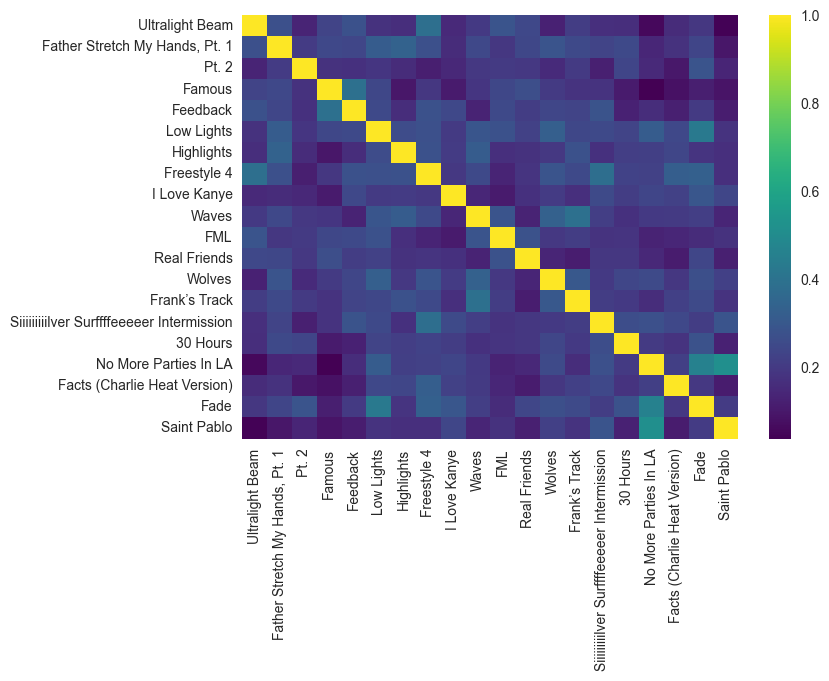

In [33]:
similarity_analysis("The Life of Pablo", "The Life of Pablo")

Dark Fantasy 		 Dark Fantasy 		 Score: 1.0000
Dark Fantasy 		 Gorgeous 		 Score: 0.1830
Dark Fantasy 		 POWER 		 Score: 0.1730
Dark Fantasy 		 All of the Lights 		 Score: 0.1759
Dark Fantasy 		 Monster 		 Score: 0.2135
Dark Fantasy 		 So Appalled 		 Score: 0.0697
Dark Fantasy 		 Devil In a New Dress 		 Score: 0.1554
Dark Fantasy 		 Runaway 		 Score: 0.2881
Dark Fantasy 		 Hell of a Life 		 Score: 0.3435
Dark Fantasy 		 Blame Game 		 Score: 0.0580
Dark Fantasy 		 Lost In the World 		 Score: 0.1868
Dark Fantasy 		 Who Will Survive In America 		 Score: 0.1645
Dark Fantasy 		 See Me Now 		 Score: 0.2770
Gorgeous 		 Dark Fantasy 		 Score: 0.1830
Gorgeous 		 Gorgeous 		 Score: 1.0000
Gorgeous 		 POWER 		 Score: 0.2614
Gorgeous 		 All of the Lights 		 Score: 0.2532
Gorgeous 		 Monster 		 Score: 0.2845
Gorgeous 		 So Appalled 		 Score: 0.3011
Gorgeous 		 Devil In a New Dress 		 Score: 0.2613
Gorgeous 		 Runaway 		 Score: 0.3276
Gorgeous 		 Hell of a Life 		 Score: 0.2381
Gorgeous 		 Blame Game

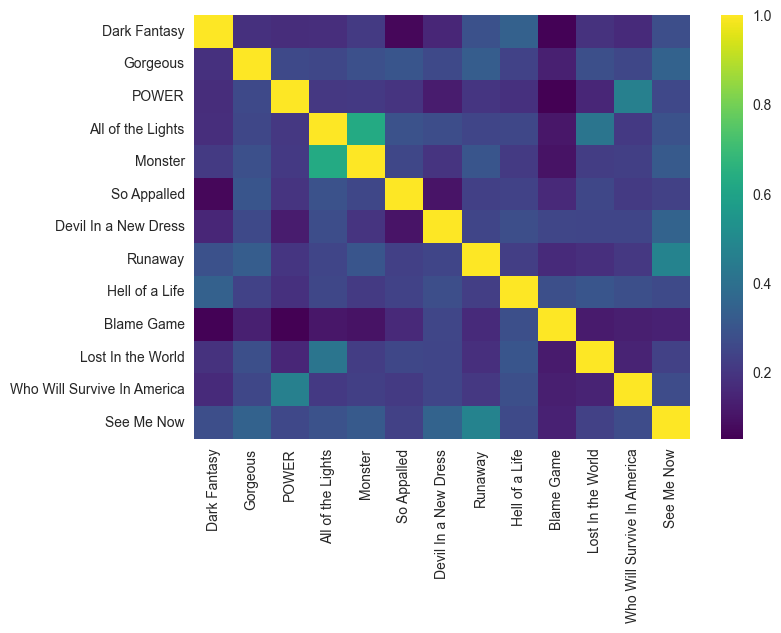

In [34]:
similarity_analysis("My Beautiful Dark Twisted Fantasy", "My Beautiful Dark Twisted Fantasy")

# Collocation analysis of highly ranked words
Goal of this task is to find how the highest-ranking words for each album are collocated and what their most common neighbours are

In [35]:
# colText = nltk.Text(albums[""].split())
# colText.collocations(10)
df_lyrics = pd.DataFrame.from_dict(albums, orient="index") # i use them all connected, given the threshold is at least 5 occurences, the collocation occuring on the end of one song and the beginning of another one should mess with my results
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True) # vectorize
tfidf_vector  = tfidf_vectorizer.fit_transform(df_lyrics[0]) # fit
tfidf_vector.toarray()
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=df_lyrics.index, columns=tfidf_vectorizer.get_feature_names_out()) # create matrix itself

tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'album','level_1': 'term', 'level_2': 'term'})
display(tfidf_df)
top_5 = tfidf_df.sort_values(by=['album','tfidf'], ascending=[True,False]).groupby(['album']).head(5)

#we extract top 5 most important words in each album
top5_dropout = top_5[top_5["album"] == "The College Dropout"]
top5_registration = top_5[top_5["album"] == "Late Registration"]
top5_graduation = top_5[top_5["album"] == "Graduation"]
top5_808s = top_5[top_5["album"] == "808s & Heartbreak"]
top5_mbdtf = top_5[top_5["album"] == "My Beautiful Dark Twisted Fantasy"]
top5_yeezus = top_5[top_5["album"] == "Yeezus"]
top5_tlop = top_5[top_5["album"] == "The Life of Pablo"]
top5_ye = top_5[top_5["album"] == "Ye"]
top5_jik = top_5[top_5["album"] == "Jesus Is King"]
top5_donda = top_5[top_5["album"] == "Donda"]
top5_ksg = top_5[top_5["album"] == "Kids See Ghosts"]
top5_wtt = top_5[top_5["album"] == "Watch The Throne"]


# test.loc[test["bmi"] < 18.5, "healthy_weight"] = -1

,album,term,tfidf
0,The College Dropout,03,0.000000
1,The College Dropout,05,0.000000
2,The College Dropout,106,0.019856
3,The College Dropout,11,0.041670
4,The College Dropout,12,0.033619
...,...,...,...
68023,Watch The Throne,zöld,0.000000
68024,Watch The Throne,ándale,0.000000
68025,Watch The Throne,ölén,0.000000
68026,Watch The Throne,úgy,0.000000


In [36]:
top5_ksg

,album,term,tfidf
58618,Kids See Ghosts,forward,0.174859
58707,Kids See Ghosts,gat,0.168636
58677,Kids See Ghosts,ga,0.164212
60715,Kids See Ghosts,reborn,0.136374
59981,Kids See Ghosts,movin,0.133091


In [37]:
def find_collocations(top5):
    album = list(top5["album"])[0]
    terms = top5["term"]
    bigram_measures = nltk.collocations.BigramAssocMeasures()

    for word in terms:

        term_filter = lambda *w: word not in w
        finder = nltk.collocations.BigramCollocationFinder.from_words(albums[album].split(), window_size = 2)

        finder.apply_freq_filter(5)
        finder.apply_ngram_filter(term_filter)

        display(f"Most common bigrams for {word}: ")
        display(finder.ngram_fd)

In [38]:
find_collocations(top5_mbdtf)

'Most common bigrams for ridiculous: '

FreqDist({('fuckin', 'ridiculous'): 20, ('ridiculous', 'fuckin'): 9})

'Most common bigrams for concert: '

FreqDist({('hand', 'concert'): 9, ('concert', 'need'): 6})

'Most common bigrams for toast: '

FreqDist({('let', 'toast'): 12})

'Most common bigrams for slowly: '

FreqDist({('feel', 'slowly'): 6, ('slowly', 'drift'): 6})

'Most common bigrams for motherfuckin: '

FreqDist({('motherfuckin', 'monster'): 9, ('know', 'motherfuckin'): 7})

In [39]:
find_collocations(top5_ye)

'Most common bigrams for someday: '

FreqDist({})

'Most common bigrams for genie: '

FreqDist({('genie', 'bottle'): 5})

'Most common bigrams for menacin: '

FreqDist({('could', 'menacin'): 6, ('menacin', 'frightenin'): 6})

'Most common bigrams for scare: '

FreqDist({('sometimes', 'scare'): 6})

'Most common bigrams for mistake: '

FreqDist({('make', 'mistake'): 10, ('mistake', 'girl'): 10})